In [1]:
import pandas as pd
import torch
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback, 
    EvalPrediction
)
from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\Gibran\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === 1. Load Dataset (Data Lama dan Baru) ===
hoax_lama = pd.read_csv('..\dataset TA - data fake fix.csv')  # Data hoax lama
real_lama = pd.read_csv('..\dataset TA - data real fix.csv')  # Data real lama

hoax_baru = pd.read_csv('..\dataset TA - faqe baru.csv')  # Data hoax baru
real_baru = pd.read_csv('..\dataset TA - riyal baru.csv')  # Data real baru

# === 2. Gabungkan Data Lama dan Baru ===
combined_lama = pd.concat([hoax_lama, real_lama], axis=0)
combined_baru = pd.concat([hoax_baru, real_baru], axis=0)

print("Dataset Information:\n", combined_lama.info())
print("Dataset Information:\n", combined_baru.info())
print("Contoh Data:\n", combined_lama.head())
print("Contoh Data:\n", combined_baru.head())


# Simpan ke CSV
combined_lama.to_csv('data lama.csv', index=False)
combined_baru.to_csv('data baru.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 0 to 217
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       491 non-null    object
 1   URL        491 non-null    object
 2   Title      491 non-null    object
 3   Narrative  491 non-null    object
 4   Statement  491 non-null    object
 5   Label      491 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 26.9+ KB
Dataset Information:
 None
<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 0 to 47
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       107 non-null    object
 1   URL        107 non-null    object
 2   Title      107 non-null    object
 3   Narrative  107 non-null    object
 4   Statement  107 non-null    object
 5   Label      107 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.9+ KB
Dataset Information:
 None
Contoh Data:
           

In [3]:
# === 3. Preprocessing (Sama seperti Sebelumnya) ===
def remove_emoji(text):
    emoji_pattern = re.compile("["    
                                u"\U0001F600-\U0001F64F"
                                u"\U0001F300-\U0001F5FF"
                                u"\U0001F680-\U0001F6FF"
                                u"\U0001F700-\U0001F77F"
                                u"\U0001F780-\U0001F7FF"
                                u"\U0001F800-\U0001F8FF"
                                u"\U00002600-\U000026FF"
                                u"\U00002700-\U000027BF"
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_special_chars(text):
    text = re.sub(r'[\[\]@]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return text

def lowercase_text(text):
    return text.lower()

def preprocess_text(text):
    text = remove_emoji(text)
    text = remove_special_chars(text)
    text = lowercase_text(text)
    return text

# Terapkan Preprocessing
combined_lama['Narrative'] = combined_lama['Narrative'].apply(preprocess_text)
combined_lama['Statement'] = combined_lama['Statement'].apply(preprocess_text)

combined_baru['Narrative'] = combined_baru['Narrative'].apply(preprocess_text)
combined_baru['Statement'] = combined_baru['Statement'].apply(preprocess_text)

In [4]:
# === 4. Bagi Data Lama Menjadi Train dan Validation ===
train_texts, val_texts, train_labels, val_labels = train_test_split(
    combined_lama[['Statement', 'Narrative']],
    combined_lama['Label'],
    test_size=0.2,  # 20% untuk validation
    stratify=combined_lama['Label'],
    random_state=42
)

# Data Baru Sebagai Test Set
test_texts = combined_baru[['Statement', 'Narrative']]
test_labels = combined_baru['Label']

# Konfirmasi Jumlah Data
print(f"Jumlah Data Train: {len(train_texts)}")
print(f"Jumlah Data Validation: {len(val_texts)}")
print(f"Jumlah Data Test (Baru): {len(test_texts)}")

Jumlah Data Train: 392
Jumlah Data Validation: 99
Jumlah Data Test (Baru): 107


In [5]:
# Gabungkan kembali data Train
train_df = pd.DataFrame({
    'Statement': train_texts['Statement'],
    'Narrative': train_texts['Narrative'],
    'Label': train_labels
})

# Gabungkan kembali data Test
val_df = pd.DataFrame({
    'Statement': val_texts['Statement'],
    'Narrative': val_texts['Narrative'],
    'Label': val_labels
})

# Gabungkan kembali data Test
test_df = pd.DataFrame({
    'Statement': test_texts['Statement'],
    'Narrative': test_texts['Narrative'],
    'Label': test_labels
})

# Simpan ke CSV
train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("Dataset Train dan Test berhasil disimpan:")
print(f"Jumlah Data Train: {train_df.shape[0]}")
print(f"Jumlah Data Validation : {val_df.shape[0]}")
print(f"Jumlah Data Test : {test_df.shape[0]}")


Dataset Train dan Test berhasil disimpan:
Jumlah Data Train: 392
Jumlah Data Validation : 99
Jumlah Data Test : 107


In [6]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Tokenisasi untuk Simple Model
train_encodings_simple = tokenizer(list(train_texts['Statement']), truncation=True, padding=True, max_length=512)
val_encodings_simple = tokenizer(list(val_texts['Statement']), truncation=True, padding=True, max_length=512)
test_encodings_simple = tokenizer(list(test_texts['Statement']), truncation=True, padding=True, max_length=512)

# Tokenisasi untuk NLI Model (Statement + Narrative)
train_encodings_nli = tokenizer(list(train_texts['Statement']), list(train_texts['Narrative']), truncation=True, padding=True, max_length=512)
val_encodings_nli = tokenizer(list(val_texts['Statement']), list(val_texts['Narrative']), truncation=True, padding=True, max_length=512)
test_encodings_nli = tokenizer(list(test_texts['Statement']), list(test_texts['Narrative']), truncation=True, padding=True, max_length=512)

C:\Users\Gibran\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# === 6. Dataset PyTorch ===
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

train_dataset_simple = NewsDataset(train_encodings_simple, train_labels)
val_dataset_simple = NewsDataset(val_encodings_simple, val_labels)
test_dataset_simple = NewsDataset(test_encodings_simple, test_labels)

train_dataset_nli = NewsDataset(train_encodings_nli, train_labels)
val_dataset_nli = NewsDataset(val_encodings_nli, val_labels)
test_dataset_nli = NewsDataset(test_encodings_nli, test_labels)

In [8]:
# Fungsi untuk Menghitung Akurasi
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [9]:
# === 7. Training (Simple Model) ===
simple_model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", num_labels=2
)

training_args_simple = TrainingArguments(
    output_dir="./results_simple",
    evaluation_strategy="epoch",              
    save_strategy="epoch",                    
    logging_strategy="epoch",                 # Logging train_loss dan eval_loss setiap epoch
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.2,
    logging_dir="./logs_simple"
)

trainer_simple = Trainer(
    model=simple_model,
    args=training_args_simple,
    train_dataset=train_dataset_simple,
    eval_dataset=val_dataset_simple,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]

)

trainer_simple.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Gibran\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 25%|██▌       | 25/100 [20:26<50:02, 40.03s/it]  

{'loss': 0.5318, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.0}


                                                
 25%|██▌       | 25/100 [22:41<50:02, 40.03s/it]

{'eval_loss': 0.30914974212646484, 'eval_accuracy': 0.8888888888888888, 'eval_runtime': 134.4444, 'eval_samples_per_second': 0.736, 'eval_steps_per_second': 0.097, 'epoch': 1.0}


 50%|█████     | 50/100 [46:43<40:57, 49.14s/it]  

{'loss': 0.2831, 'learning_rate': 5e-06, 'epoch': 2.0}


                                                
 50%|█████     | 50/100 [48:56<40:57, 49.14s/it]

{'eval_loss': 0.27302759885787964, 'eval_accuracy': 0.8686868686868687, 'eval_runtime': 133.2402, 'eval_samples_per_second': 0.743, 'eval_steps_per_second': 0.098, 'epoch': 2.0}


 75%|███████▌  | 75/100 [1:12:37<18:30, 44.40s/it]

{'loss': 0.1856, 'learning_rate': 2.5e-06, 'epoch': 3.0}


                                                  
 75%|███████▌  | 75/100 [1:14:50<18:30, 44.40s/it]

{'eval_loss': 0.22252903878688812, 'eval_accuracy': 0.898989898989899, 'eval_runtime': 132.55, 'eval_samples_per_second': 0.747, 'eval_steps_per_second': 0.098, 'epoch': 3.0}


100%|██████████| 100/100 [1:34:12<00:00, 39.86s/it]

{'loss': 0.1272, 'learning_rate': 0.0, 'epoch': 4.0}


                                                   
100%|██████████| 100/100 [1:36:25<00:00, 39.86s/it]

{'eval_loss': 0.22795546054840088, 'eval_accuracy': 0.8888888888888888, 'eval_runtime': 133.0572, 'eval_samples_per_second': 0.744, 'eval_steps_per_second': 0.098, 'epoch': 4.0}


100%|██████████| 100/100 [1:36:28<00:00, 39.86s/it]

{'train_runtime': 5788.5426, 'train_samples_per_second': 0.271, 'train_steps_per_second': 0.017, 'train_loss': 0.28192577362060545, 'epoch': 4.0}


100%|██████████| 100/100 [1:36:28<00:00, 57.89s/it]


TrainOutput(global_step=100, training_loss=0.28192577362060545, metrics={'train_runtime': 5788.5426, 'train_samples_per_second': 0.271, 'train_steps_per_second': 0.017, 'train_loss': 0.28192577362060545, 'epoch': 4.0})

In [10]:
# === 8. Training (NLI Model) ===

# Custom Model untuk NLI (Dengan Dropout)
class CustomNLIModel(AutoModelForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(0.1)

nli_model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", num_labels=2
)

training_args_nli = TrainingArguments(
    output_dir="./results_nli",
    evaluation_strategy="epoch",              
    save_strategy="epoch",                    
    logging_strategy="epoch",                 # Logging train_loss dan eval_loss setiap epoch
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.1,
    logging_dir="./logs_nli"
)

trainer_nli = Trainer(
    model=nli_model,
    args=training_args_nli,
    train_dataset=train_dataset_nli,
    eval_dataset=val_dataset_nli,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]

)

trainer_nli.train()

C:\Users\Gibran\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Gibran\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 17%|█▋        | 25/150 [18:13<1:15:58, 36.47s/it]

{'loss': 0.4456, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.0}



 17%|█▋        | 25/150 [20:08<1:15:58, 36.47s/it]

{'eval_loss': 0.19761066138744354, 'eval_accuracy': 0.9494949494949495, 'eval_runtime': 114.5638, 'eval_samples_per_second': 0.864, 'eval_steps_per_second': 0.113, 'epoch': 1.0}


 33%|███▎      | 50/150 [38:05<1:06:14, 39.75s/it]

{'loss': 0.1373, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}



 33%|███▎      | 50/150 [39:59<1:06:14, 39.75s/it]

{'eval_loss': 0.10124704241752625, 'eval_accuracy': 0.9595959595959596, 'eval_runtime': 113.7026, 'eval_samples_per_second': 0.871, 'eval_steps_per_second': 0.114, 'epoch': 2.0}


 50%|█████     | 75/150 [1:01:42<56:17, 45.04s/it]  

{'loss': 0.058, 'learning_rate': 5e-06, 'epoch': 3.0}



 50%|█████     | 75/150 [1:03:36<56:17, 45.04s/it]

{'eval_loss': 0.13584522902965546, 'eval_accuracy': 0.9595959595959596, 'eval_runtime': 114.0457, 'eval_samples_per_second': 0.868, 'eval_steps_per_second': 0.114, 'epoch': 3.0}


 50%|█████     | 75/150 [1:03:40<1:03:40, 50.95s/it]

{'train_runtime': 3820.9699, 'train_samples_per_second': 0.616, 'train_steps_per_second': 0.039, 'train_loss': 0.21364489555358887, 'epoch': 3.0}


TrainOutput(global_step=75, training_loss=0.21364489555358887, metrics={'train_runtime': 3820.9699, 'train_samples_per_second': 0.616, 'train_steps_per_second': 0.039, 'train_loss': 0.21364489555358887, 'epoch': 3.0})

In [11]:
# === Evaluasi di Test Set (Simple Model) ===
test_preds_simple = trainer_simple.predict(test_dataset_simple).predictions.argmax(axis=1)
simple_accuracy = accuracy_score(test_labels, test_preds_simple)
print(f"Accuracy: {simple_accuracy:.2f}")

# Hitung Precision, Recall, F1-Score
precision_simple = precision_score(test_labels, test_preds_simple)
recall_simple = recall_score(test_labels, test_preds_simple)
f1_simple = f1_score(test_labels, test_preds_simple)

# Print Evaluasi
print("Evaluasi Simple Model:\n")
print(f"Accuracy   : {simple_accuracy * 100:.2f}%")
print(f"Precision  : {precision_simple * 100:.2f}%")
print(f"Recall     : {recall_simple * 100:.2f}%")
print(f"F1-Score   : {f1_simple * 100:.2f}%\n")
print(classification_report(test_labels, test_preds_simple, target_names=["Real (Entailment)", "Fake (Contradiction)"]))

# Simpan Hasil Prediksi ke CSV
test_results_simple = pd.DataFrame({
    'Statement': test_texts['Statement'].values,
    'Label Asli': test_labels.values,
    'Prediksi': test_preds_simple
})

test_results_simple.to_csv('simple_model_test_results.csv', index=False)

100%|██████████| 14/14 [02:12<00:00,  9.44s/it]


Accuracy: 0.80
Evaluasi Simple Model:

Accuracy   : 80.37%
Precision  : 89.58%
Recall     : 72.88%
F1-Score   : 80.37%

                      precision    recall  f1-score   support

   Real (Entailment)       0.73      0.90      0.80        48
Fake (Contradiction)       0.90      0.73      0.80        59

            accuracy                           0.80       107
           macro avg       0.81      0.81      0.80       107
        weighted avg       0.82      0.80      0.80       107



In [23]:


# Evaluasi dan cetak classification report dengan 4 angka di belakang koma
print(classification_report(test_labels, test_preds_simple, target_names=["Real (Entailment)", "Fake (Contradiction)"], digits=4))


                      precision    recall  f1-score   support

   Real (Entailment)     0.7288    0.8958    0.8037        48
Fake (Contradiction)     0.8958    0.7288    0.8037        59

            accuracy                         0.8037       107
           macro avg     0.8123    0.8123    0.8037       107
        weighted avg     0.8209    0.8037    0.8037       107



In [ ]:
# === Evaluasi di Test Set (NLI Model) ===
test_preds_nli = trainer_nli.predict(test_dataset_nli).predictions.argmax(axis=1)
nli_accuracy = accuracy_score(test_labels, test_preds_nli)
print(f"Accuracy: {nli_accuracy:.2f}")

# Hitung Precision, Recall, F1-Score
precision_nli = precision_score(test_labels, test_preds_nli)
recall_nli = recall_score(test_labels, test_preds_nli)
f1_nli = f1_score(test_labels, test_preds_nli)

# Print Evaluasi
print("\nEvaluasi NLI Model:\n")
print(f"Accuracy   : {nli_accuracy * 100:.2f}%")
print(f"Precision  : {precision_nli * 100:.2f}%")
print(f"Recall     : {recall_nli * 100:.2f}%")
print(f"F1-Score   : {f1_nli * 100:.2f}%\n")
print(classification_report(test_labels, test_preds_nli, target_names=["Real (Entailment)", "Fake (Contradiction)"]))

# Simpan Hasil Prediksi ke CSV
test_results_nli = pd.DataFrame({
    'Statement': test_texts['Statement'].values,
    'Narrative': test_texts['Narrative'].values,
    'Label Asli': test_labels.values,
    'Prediksi': test_preds_nli
})

test_results_nli.to_csv('nli_model_test_results.csv', index=False)

100%|██████████| 14/14 [01:48<00:00,  7.72s/it]

Accuracy: 0.87

Evaluasi NLI Model:

Accuracy   : 86.92%
Precision  : 97.87%
Recall     : 77.97%
F1-Score   : 86.79%

                      precision    recall  f1-score   support

   Real (Entailment)       0.78      0.98      0.87        48
Fake (Contradiction)       0.98      0.78      0.87        59

            accuracy                           0.87       107
           macro avg       0.88      0.88      0.87       107
        weighted avg       0.89      0.87      0.87       107



In [22]:
# Evaluasi dan cetak classification report dengan 4 angka di belakang koma
print(classification_report(test_labels, test_preds_nli, target_names=["Real (Entailment)", "Fake (Contradiction)"], digits=4))


                      precision    recall  f1-score   support

   Real (Entailment)     0.7833    0.9792    0.8704        48
Fake (Contradiction)     0.9787    0.7797    0.8679        59

            accuracy                         0.8692       107
           macro avg     0.8810    0.8794    0.8691       107
        weighted avg     0.8911    0.8692    0.8690       107



In [13]:
logs = trainer_simple.state.log_history

# Ambil train_loss dan eval_loss dari log history
train_loss = [x['loss'] for x in logs if 'loss' in x]
val_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

# Cetak jumlah dan isi train_loss
print(f"Jumlah Train Loss yang Tercatat: {len(train_loss)}")
print(f"Train Loss: {train_loss}")

# Cetak jumlah dan isi val_loss
print(f"Jumlah Validation Loss yang Tercatat: {len(val_loss)}")
print(f"Validation Loss: {val_loss}")


Jumlah Train Loss yang Tercatat: 4
Train Loss: [0.5318, 0.2831, 0.1856, 0.1272]
Jumlah Validation Loss yang Tercatat: 4
Validation Loss: [0.30914974212646484, 0.27302759885787964, 0.22252903878688812, 0.22795546054840088]


In [14]:
logs = trainer_nli.state.log_history

# Ambil train_loss dan eval_loss dari log history
train_loss = [x['loss'] for x in logs if 'loss' in x]
val_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

# Cetak jumlah dan isi train_loss
print(f"Jumlah Train Loss yang Tercatat: {len(train_loss)}")
print(f"Train Loss: {train_loss}")

# Cetak jumlah dan isi val_loss
print(f"Jumlah Validation Loss yang Tercatat: {len(val_loss)}")
print(f"Validation Loss: {val_loss}")


Jumlah Train Loss yang Tercatat: 3
Train Loss: [0.4456, 0.1373, 0.058]
Jumlah Validation Loss yang Tercatat: 3
Validation Loss: [0.19761066138744354, 0.10124704241752625, 0.13584522902965546]


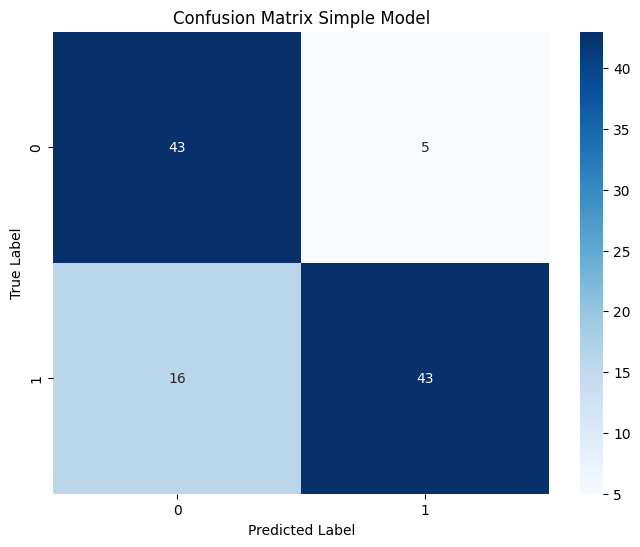

In [18]:
# Confusion Matrix
cm_nli = confusion_matrix(test_labels, test_preds_simple)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nli, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Simple Model")
plt.xlabel("Predicted Label")  # Tambahkan label untuk sumbu X
plt.ylabel("True Label")       # Tambahkan label untuk sumbu Y
plt.show()

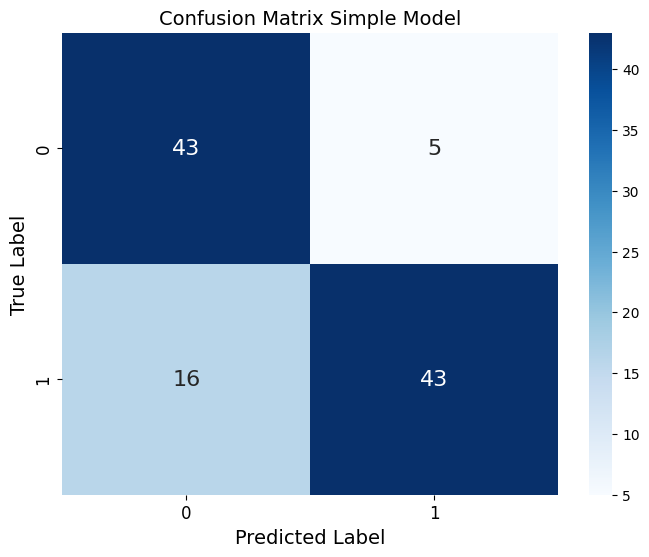

In [27]:
# Confusion Matrix
cm_nli = confusion_matrix(test_labels, test_preds_simple)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nli, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})  # Perbesar angka dalam heatmap
plt.title("Confusion Matrix Simple Model", fontsize=14)  # Perbesar judul
plt.xlabel("Predicted Label", fontsize=14)  # Perbesar label sumbu X
plt.ylabel("True Label", fontsize=14)       # Perbesar label sumbu Y|
plt.xticks(fontsize=12)  # Perbesar angka pada sumbu X
plt.yticks(fontsize=12)  # Perbesar angka pada sumbu Y
plt.show()

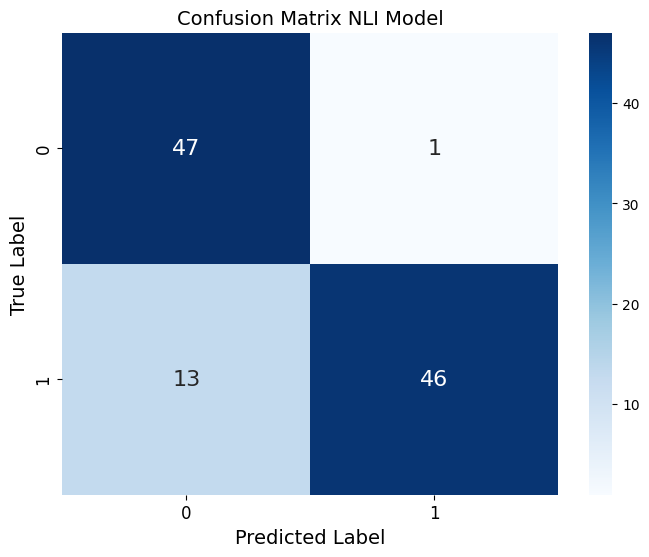

In [26]:
# Confusion Matrix
cm_nli = confusion_matrix(test_labels, test_preds_nli)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nli, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})  # Perbesar angka dalam heatmap
plt.title("Confusion Matrix NLI Model", fontsize=14)  # Perbesar judul
plt.xlabel("Predicted Label", fontsize=14)  # Perbesar label sumbu X
plt.ylabel("True Label", fontsize=14)       # Perbesar label sumbu Y
plt.xticks(fontsize=12)  # Perbesar angka pada sumbu X
plt.yticks(fontsize=12)  # Perbesar angka pada sumbu Y
plt.show()

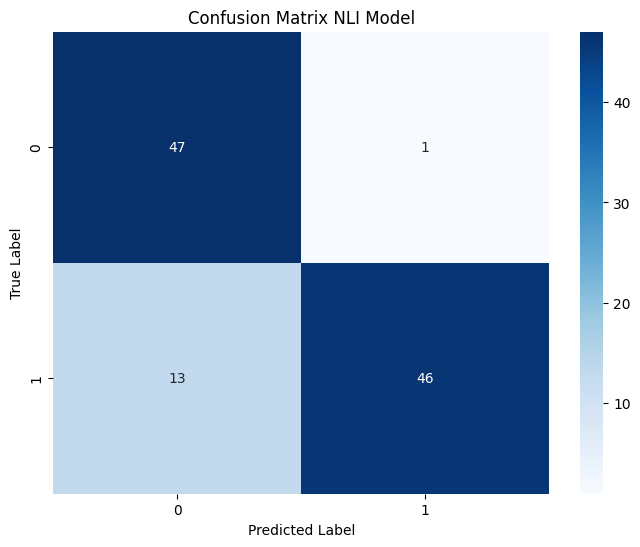

In [24]:
# Confusion Matrix
cm_nli = confusion_matrix(test_labels, test_preds_nli)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nli, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix NLI Model")
plt.xlabel("Predicted Label")  # Tambahkan label untuk sumbu X
plt.ylabel("True Label")       # Tambahkan label untuk sumbu Y
plt.show()